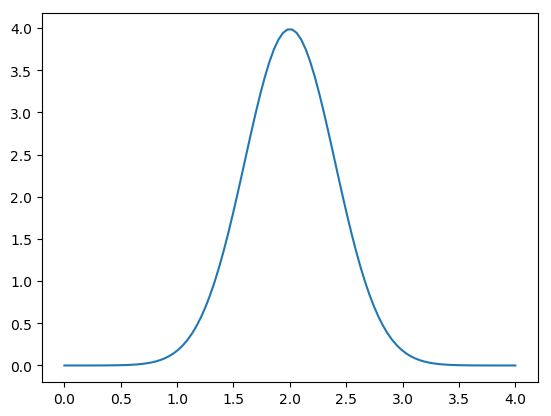

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11c7b7128>

In [1]:
using PyCall
include("src/gauss_error.jl")

a = 0.
b = 4.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x)# + norm(n2, mu2, sig2, x)
end

x = range(a, stop=b, length=100)

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
function kernel(x::Float64, y::Float64)
    n = x-y
    if n>0
        return 1
    elseif n<0
        return 0
        else return 1.0/2
    end
end

kernel (generic function with 1 method)

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]

#27 (generic function with 1 method)

In [4]:
y = Float64[]
for i = 0:50
    push!(y, a + (b - a) * i/50)
end

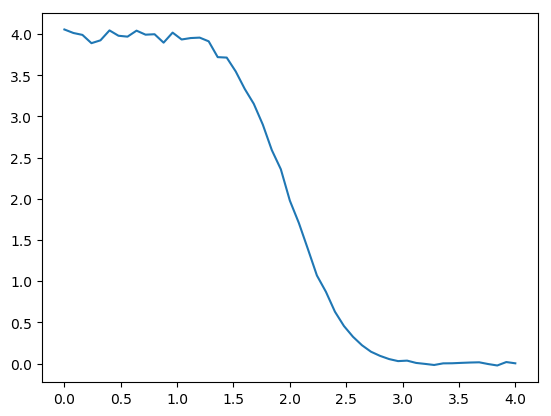

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x142709fd0>

In [5]:
ftrue = convolution.(y)
sig = 0.01*ftrue +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [6]:
basis = FourierBasis(a, b, 7)

FourierBasis(0.0, 4.0, 7, my_func[my_func(##14#18(), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0, 4.0))])

In [7]:
model = GaussErrorUnfolder(basis, omega(basis, 2))

GaussErrorUnfolder(FourierBasis(0.0, 4.0, 7, my_func[my_func(##14#18(), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0

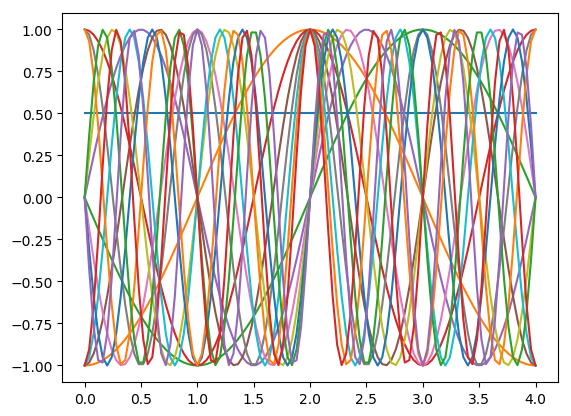

In [8]:
a = 0.
c = 4.
x = Float64[]
for i = 0:100
    push!(x, a + (c - a) * i/100)
end
for f in basis.basisFun
    plot(x, f.f.(x))
end

In [9]:
phi_reconstruct = solve(model, kernel, f, sig, y)

starting solve
ending solve
starting solve_matrix
ending solve_matrix
starting solve_correct
starting optimal_alpha
starting optimize
ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "covariance" => [0.00222504 -0.00167264 … -1.54677e-6 -0.00575019; -0.0016726…
  "phi"        => [1.98092, 1.62338, -0.0269307, 0.621513, -0.035018, 0.0508546…
  "alphas"     => [0.5]

In [10]:
println(phi_reconstruct["phi"])

[1.98092, 1.62338, -0.0269307, 0.621513, -0.035018, 0.0508546, 0.0126672, 0.000593005, 0.000439426, -0.000572798, 0.000894563, -0.000231278, -0.000203195, 0.000107725, 0.079494]


In [11]:
println(phi_reconstruct["covariance"])

[0.00222504 -0.00167264 -0.0013854 0.00059526 0.000841356 -0.000199722 -0.00021702 5.03114e-5 6.17464e-5 -1.59112e-5 -2.45271e-5 1.15002e-5 9.10008e-6 -1.54677e-6 -0.00575019; -0.00167264 0.00381852 0.00126314 -0.000197426 -0.00134244 0.00021059 0.000231373 -3.62923e-5 -7.01578e-5 1.47663e-5 2.78774e-5 -1.17337e-5 -1.01338e-5 1.27442e-6 0.00641563; -0.0013854 0.00126314 0.00240331 0.000602293 3.17397e-5 0.000114013 -6.90773e-6 -1.28017e-5 9.40946e-6 3.39062e-6 -3.38238e-6 -3.49768e-7 1.44165e-6 6.15857e-7 -0.000982363; 0.00059526 -0.000197426 0.000602293 0.00637329 0.000480782 9.51453e-5 -0.000387258 5.44839e-5 6.26279e-5 -6.52373e-6 -2.39691e-5 9.0553e-6 9.14054e-6 -7.44248e-7 -0.00546801; 0.000841356 -0.00134244 3.17397e-5 0.000480782 0.00290614 0.000180656 1.36677e-5 7.23663e-6 4.13655e-6 -1.95739e-6 1.36317e-6 1.61506e-7 -3.9306e-7 -3.5177e-7 0.0003178; -0.000199722 0.00021059 0.000114013 9.51453e-5 0.000180656 0.00333712 3.33787e-5 1.13313e-5 -4.15623e-5 6.65593e-6 7.74571e-6 -2.3

In [12]:
phivec = PhiVec(phi_reconstruct["phi"], basis, phi_reconstruct["covariance"])

PhiVec([1.98092, 1.62338, -0.0269307, 0.621513, -0.035018, 0.0508546, 0.0126672, 0.000593005, 0.000439426, -0.000572798, 0.000894563, -0.000231278, -0.000203195, 0.000107725, 0.079494], FourierBasis(0.0, 4.0, 7, my_func[my_func(##14#18(), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##16#20{Float6

In [13]:
function call(phi::PhiVec, x::Float64)
    res = 0.
    for i = 1:(length(phi.coeff))
        res += phi.coeff[i] * phi.basis.basisFun[i].f(x)
    end
    return res
end

call (generic function with 2 methods)

In [14]:
call(phivec, 1.)

0.48797093700312705

In [15]:
result = Float64[]
for x0 in x
    push!(result, call(phivec, x0))
end
println(result)

[-0.0614376, -0.101415, -0.136373, -0.16083, -0.171469, -0.167718, -0.151795, -0.128204, -0.102802, -0.0815919, -0.0694837, -0.0692586, -0.0809337, -0.10165, -0.126103, -0.147441, -0.158457, -0.152846, -0.1263, -0.0772261, -0.00695313, 0.0806049, 0.179767, 0.284224, 0.388283, 0.487971, 0.581792, 0.67099, 0.759268, 0.852005, 0.955138, 1.0739, 1.21168, 1.36917, 1.54409, 1.73132, 1.92368, 2.11301, 2.29146, 2.45267, 2.59271, 2.71053, 2.80787, 2.88861, 2.95782, 3.02052, 3.08045, 3.13923, 3.19584, 3.24667, 3.28611, 3.30757, 3.3047, 3.27261, 3.20887, 3.11406, 2.99184, 2.84835, 2.69134, 2.52887, 2.36809, 2.21412, 2.06943, 1.93365, 1.80398, 1.67603, 1.54498, 1.40678, 1.25924, 1.10267, 0.940084, 0.776825, 0.619732, 0.475984, 0.35185, 0.251576, 0.176634, 0.125456, 0.0937332, 0.0751996, 0.0627697, 0.0498105, 0.0313096, 0.00471952, -0.0296789, -0.0689607, -0.108251, -0.141793, -0.164185, -0.171549, -0.162402, -0.13807, -0.102552, -0.0618717, -0.0230257, 0.00726328, 0.0237563, 0.0236412, 0.00702831,

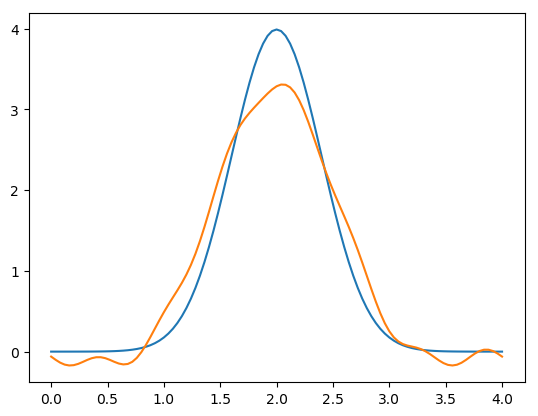

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11c76a9e8>

In [16]:
plot(x, phi.(x))
plot(x, result)

In [18]:
result_error = error(phivec, x)

ok2
0.5


MethodError: MethodError: no method matching (::getfield(Main, Symbol("##15#19")){Float64,Float64,Int64})(::Array{Float64,1})
Closest candidates are:
  #15(!Matched::Float64) at /Users/ta_nyan/Documents/phystech/statreg/src/basis.jl:122